In [1]:
import os, sys
from tqdm import tqdm
import seaborn as sns
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from modules.preprocessing import *
from modules.io import *
from modules.learning import *
from modules.patterns import *
from modules.statistics import *
from modules.plots import *
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from IPython.display import display
from sklearn.preprocessing import normalize
import seaborn
import pickle
from tqdm.notebook import tqdm
import joblib
plt.style.use('ggplot')

# Test the performance of the yaw misalignment regression method

# Load Data

In [2]:
dataset_file = '/data/data2/engie_initial/post_treated_data/BEZ/BEBEZE02_scada_high_frequency.parquet'
df = load_df(dataset_file)
df = df.dropna(axis=1, how='all')
df.columns = df.columns.str.replace('cor. ', '', regex=False)
cols = ['wind speed', 'pitch angle', 'rotor speed', 'active power',
        'nacelle direction', 'wind direction']
df = df[cols]

# Resample and apply filters

Resample Complete
Groupping Complete
Chunk Interpolate Done
Interpolate Complete
Filter Complete
Filter Complete
Filter Complete
Filter Complete


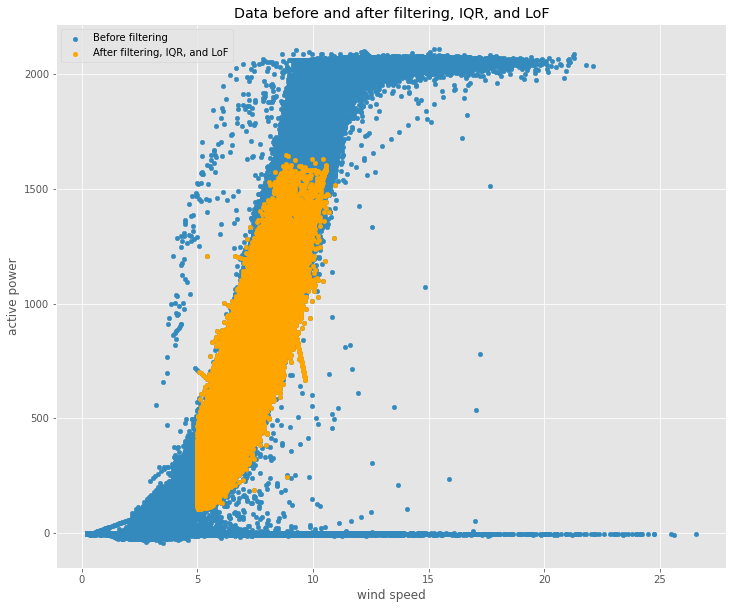

In [3]:
granularity = '1min'
# Resample with 60second granularity
df=change_granularity(df,granularity=granularity)

# calculate dynamic yaw misalignment and take a 60-min rolling mean
df["theta_d"] = (df['wind direction'] - df['nacelle direction']) % 360
df["theta_d"][df["theta_d"] > +180] -= 360
df["theta_d"][df["theta_d"] < -180] += 360
df["theta_d"] = df["theta_d"].rolling(60).mean()
df = df.dropna()

df_initial = df.copy()

# Perform IQR outlier removal
df = outliers_IQR(df)

# drop values of wind speed under 5m/s
df=filter_col(df, 0, less_than=5, bigger_than=11)

# drop values with pitch angle higher than 2 degrees or lower than -2 degrees
df=filter_col(df, 1, less_than=-2, bigger_than=2)

# drop values of rotor speed under 8rpm
df=filter_col(df, 2, less_than=8, bigger_than=15)

# drop values of power near the power_limit and near or below zero

power_limit = 2050
df=filter_col(df, 4, less_than=1e-4, bigger_than= 0.95 * power_limit)


# Keep only dates with lidar measurements
start = '2018-06-02'
end = '2019-01-11'
df = filter_dates(df, start, end)

# Remove Outliers using LoF
df = outliers_LoF(df).copy()

# Uncomment for plots
ax1=df_initial.plot.scatter(x='wind speed', y='active power', figsize=(12, 10), label='Before filtering')
df.plot.scatter(ax=ax1, x='wind speed', y='active power', c='orange', label = 'After filtering, IQR, and LoF')
plt.title(f"Data before and after filtering, IQR, and LoF")
plt.show()

# Add a column with the measured static yaw misalignment

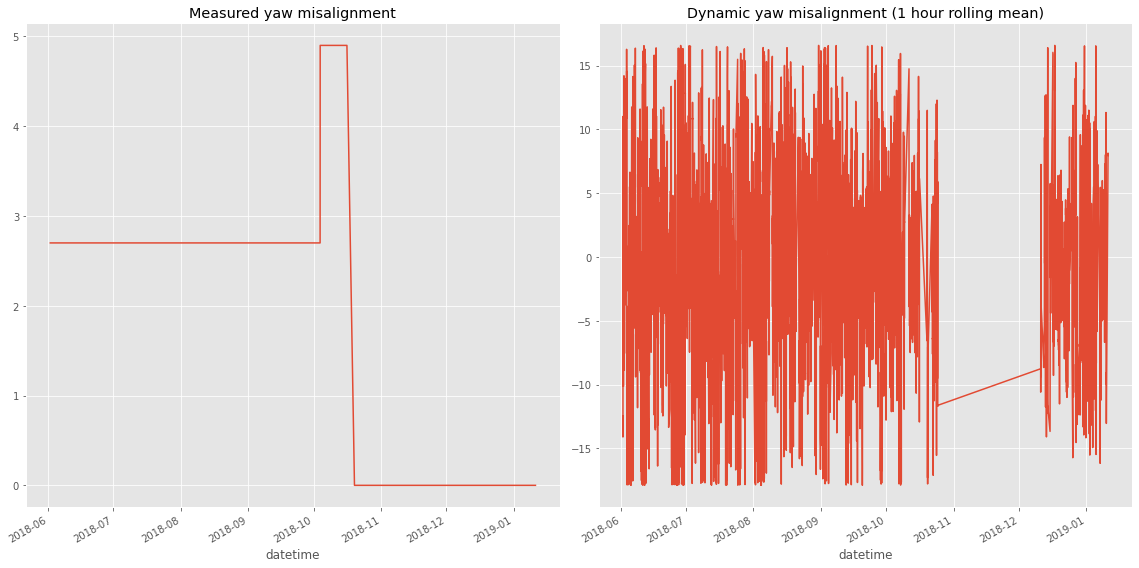

In [4]:
df_labels = pd.read_csv('/data/data2/panos/Yaw.csv')
df["y"] = np.nan
df_l = df_labels[df_labels.Turbines == dataset_file]
for start, end, static in zip(df_l.StartDate, df_l.EndDate, df_l.StaticYaw):
    df.loc[start:end, 'y'] = static
df = df.dropna()
static_misalignment_values = list(df_l.StaticYaw.values)
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
# df.index = df.index.map(str)
ax1 = df['y'].plot(x = df.index.to_series().dt.date, ax=axs[0])
ax1.set_title(f"Measured yaw misalignment")

ax2 = df['theta_d'].plot(ax=axs[1])
ax2.set_title(f"Dynamic yaw misalignment (1 hour rolling mean)")
plt.tight_layout()
plt.show()

### Split dataset into bins based on wind speed

In [5]:
bin_size = 1
min_speed = 5
max_speed = 11
bins = np.arange(min_speed, max_speed, bin_size)
bins = np.append(bins,max_speed)
print(bins)
bin_masks = []
bin_feature = 'wind speed'
for i in range(len(bins) - 1):
    mask = (df[bin_feature]>= bins[i]) & (df[bin_feature] < bins[i + 1])
    bin_masks.append(mask)

[ 5  6  7  8  9 10 11]


# Estimate the yaw angle using per-point predictions of the trained model

In [6]:
scaler_file = 'select_bins_yaw_scaler.pickle'
models_file = 'models_bins.pickle.z' 

with open(models_file, 'rb') as file:
    all_models_dict = joblib.load(file)
    
with open(scaler_file, 'rb') as file:
    scaler = pickle.load(file)
    
df_scaled = df.copy()
df_scaled[df_scaled.columns] = scaler.transform(df_scaled)
df_scaled['y'] = df['y']

    
binned_data_dfs = []
for b in bin_masks:
    df_temp = df_scaled[b]
    binned_data_dfs.append(df_temp.copy())
    
target_feature = 'y'

print(static_misalignment_values)
all_preds = {}
for bin_n, d in enumerate(binned_data_dfs):
    print(f'evaluating with models trained on bin {bin_n}')
    dataset_preds = []
    for dataset_key, dataset_dict in all_models_dict.items():
        print(f"Dataset : {dataset_key}")
        fit_features = dataset_dict['selected_features']
        models = dataset_dict['models']
        if d.shape[0] >= 100 and models[bin_n] is not None:
            test_preds = predict(d, models[bin_n], fit_features, target_feature)
            print(test_preds.shape)
            dataset_preds.append(test_preds)
            r_sq, mae, me, mape, mpe, _ = score(d[target_feature].values, test_preds)
        else:
            pass
    if dataset_preds != []:
        all_preds[bin_n] = np.mean(dataset_preds, axis=0)
    else:
        all_preds[bin_n] = None

[2.7, 2.7, 4.9, 0.0, 0.0]
evaluating with models trained on bin 0
Dataset : 1/BEBEZE01_scada_high_frequency.parquet
(38210,)
Dataset : 2/BEBEZE03_scada_high_frequency.parquet
(38210,)
evaluating with models trained on bin 1
Dataset : 1/BEBEZE01_scada_high_frequency.parquet
(29935,)
Dataset : 2/BEBEZE03_scada_high_frequency.parquet
(29935,)
evaluating with models trained on bin 2
Dataset : 1/BEBEZE01_scada_high_frequency.parquet
(19286,)
Dataset : 2/BEBEZE03_scada_high_frequency.parquet
(19286,)
evaluating with models trained on bin 3
Dataset : 1/BEBEZE01_scada_high_frequency.parquet
(9991,)
Dataset : 2/BEBEZE03_scada_high_frequency.parquet
(9991,)
evaluating with models trained on bin 4
Dataset : 1/BEBEZE01_scada_high_frequency.parquet
(2415,)
Dataset : 2/BEBEZE03_scada_high_frequency.parquet
(2415,)
evaluating with models trained on bin 5
Dataset : 1/BEBEZE01_scada_high_frequency.parquet
(179,)
Dataset : 2/BEBEZE03_scada_high_frequency.parquet
(179,)


# Plot the results

RMSE = 1.932097049526388
MAE = 1.748542335946509


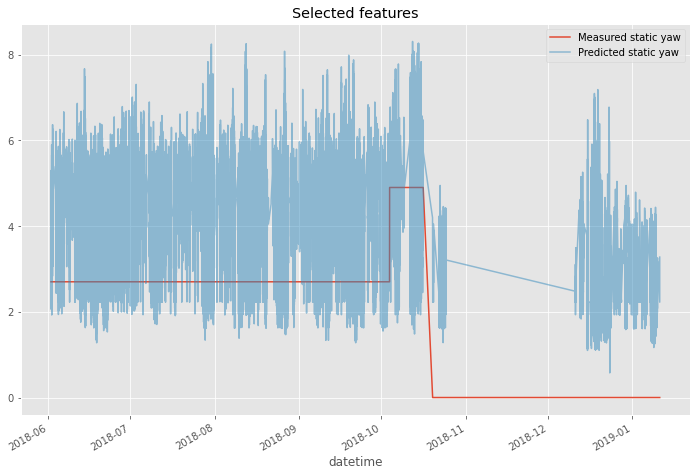

In [7]:
df['y_pred'] = np.nan
for bin_n, b in enumerate(bin_masks):
    if all_preds[bin_n] is not None:
        predictions = all_preds[bin_n]
        df.loc[b, 'y_pred'] = predictions
prediction = np.abs(df['y_pred'])
target = np.abs(df['y'])

# Calculate RMSE and MAE
rmse = np.sqrt(np.nanmean((prediction.values-target.values)**2))
mae = np.nanmean(np.abs(prediction.values-target.values))
m = (prediction.isna())
print(f"RMSE = {rmse}")
print(f"MAE = {mae}")

df_true_yaw = pd.DataFrame()
df_true_yaw['y'] = np.abs(df['y'])
df_true_yaw['y'].plot(figsize=(12, 8), label = 'Measured static yaw')
df['y_pred'].plot(alpha=0.5, label = 'Predicted static yaw')
plt.title('Selected features')
plt.legend()
plt.show()

# Plot the smoothened results

RMSE = 1.8598836646344765
MAE = 1.7558039541225676


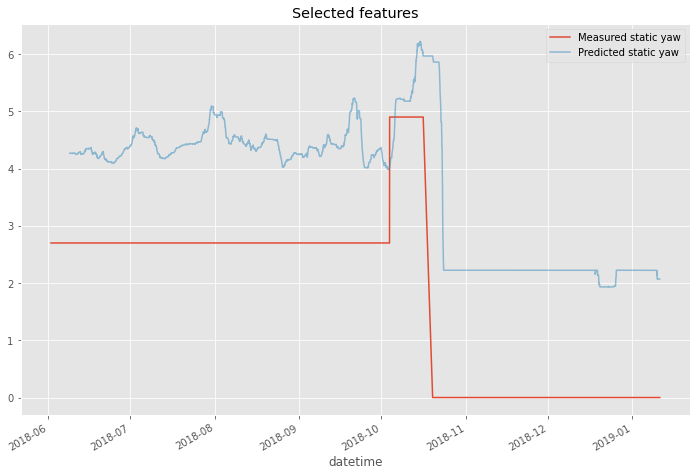

In [8]:
days = 2
df['y_pred'] = np.nan
for bin_n, b in enumerate(bin_masks):
    if all_preds[bin_n] is not None:
        predictions = all_preds[bin_n]
        df.loc[b, 'y_pred'] = predictions
        df = df.ffill()
        
prediction = np.abs(df['y_pred'].rolling(days * 1440).median())
target = np.abs(df['y'])

# Calculate RMSE and MAE
rmse = np.sqrt(np.nanmean((prediction.values-target.values)**2))
mae = np.nanmean(np.abs(prediction.values-target.values))
print(f"RMSE = {rmse}")
print(f"MAE = {mae}")

df_true_yaw = pd.DataFrame()
df_true_yaw['y'] = np.abs(df['y'])
df_true_yaw['y'].plot(figsize=(12, 8), label = 'Measured static yaw')
df['y_pred'].rolling(days * 1440).median().plot(alpha=0.5, label = 'Predicted static yaw')
plt.title('Selected features')
plt.legend()
plt.show()

# Further exploration

[0.  2.7 4.9]


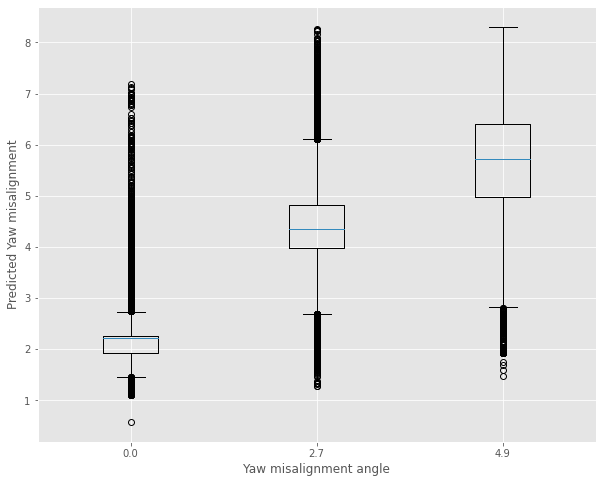

In [9]:
#code for boxplots
angles = np.sort(np.abs(np.unique(static_misalignment_values)))
fig, ax = plt.subplots(figsize=(10, 8))
bin_data = []
means = [np.nan]
print(angles)
for theta_s in angles:
    df['y'] = np.abs(df['y'])
    df_temp = df[df['y'] == theta_s].copy()
    bin_data.append(df_temp.y_pred.values.ravel())
ax.boxplot(bin_data)
locs = ax.get_xticks()
ax.set_ylabel('Predicted Yaw misalignment')
ax.set_xlabel('Yaw misalignment angle')
ax.set_xticklabels(angles)
plt.show()

[0.  2.7 4.9]
(15965, 1)
(66694, 1)
(7892, 1)


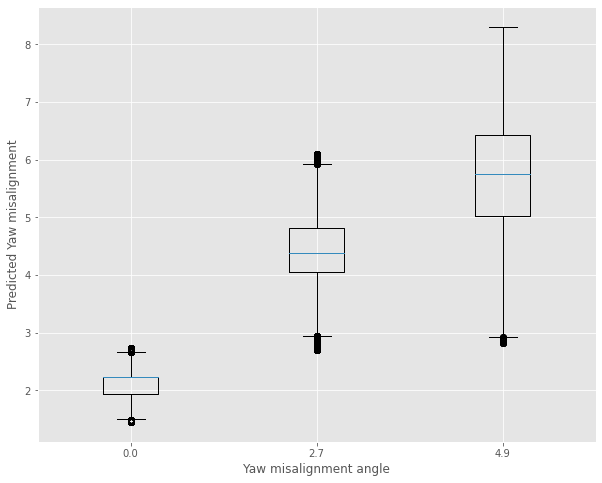

In [10]:
#code for boxplots
angles = np.sort(np.abs(np.unique(static_misalignment_values)))
fig, ax = plt.subplots(figsize=(10, 8))
bin_data = []
means = [np.nan]
print(angles)
angle_medians = {}
for theta_s in angles:
    df['y'] = np.abs(df['y'])
    df_temp = df[df['y'] == theta_s].copy()
    frame = outliers_IQR(df_temp['y_pred'].to_frame())
    angle_medians[str(theta_s)] = np.median(frame)
    print(frame.values.shape)
    bin_data.append(frame.values.ravel())
ax.boxplot(bin_data)
locs = ax.get_xticks()
ax.set_ylabel('Predicted Yaw misalignment')
ax.set_xlabel('Yaw misalignment angle')
ax.set_xticklabels(angles)
plt.show()

RMSE = 1.7463503856489104
MAE = 1.7148878205315181


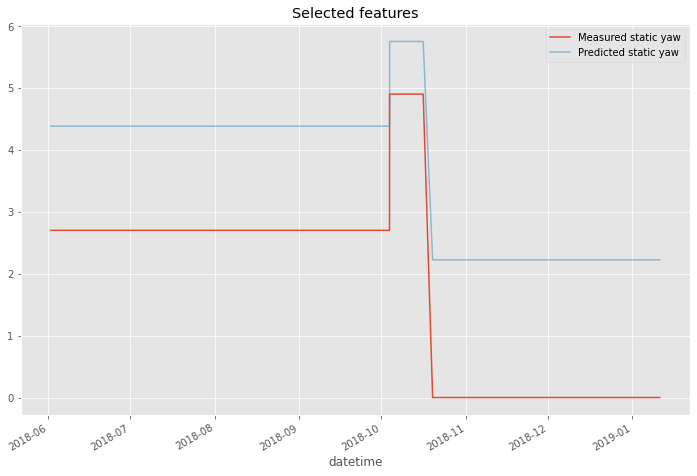

In [11]:
for th_s, med in angle_medians.items(): 
    df['y_pred'][df['y']==float(th_s)] = med

prediction = np.abs(df['y_pred'])
target = np.abs(df['y'])

rmse = np.sqrt(np.nanmean((prediction.values-target.values)**2))
mae = np.nanmean(np.abs(prediction.values-target.values))
m = (prediction.isna())
print(f"RMSE = {rmse}")
print(f"MAE = {mae}")

target.plot(figsize=(12, 8), label = 'Measured static yaw')
prediction.plot(alpha=0.5, label = 'Predicted static yaw')
plt.title('Selected features')
plt.legend()
plt.show()

WINDOW 0
WINDOW 2880
WINDOW 5760
WINDOW 8640
WINDOW 11520
WINDOW 14400
WINDOW 17280
WINDOW 20160
WINDOW 23040
WINDOW 25920
WINDOW 28800
WINDOW 31680
WINDOW 34560
WINDOW 37440
WINDOW 40320
WINDOW 43200
WINDOW 46080
WINDOW 48960
WINDOW 51840
WINDOW 54720
WINDOW 57600
WINDOW 60480
WINDOW 63360
WINDOW 66240
WINDOW 69120
WINDOW 72000
WINDOW 74880
WINDOW 77760
WINDOW 80640
WINDOW 83520
WINDOW 86400
WINDOW 89280
WINDOW 92160
WINDOW 95040
WINDOW 97920
RMSE = 1.7709328270193072
MAE = 1.7055151681216087


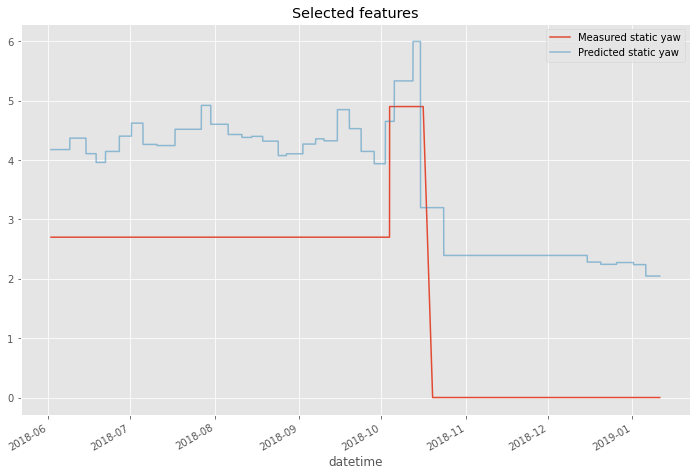

In [12]:
# specify the file to load the trained models from
scaler_file = 'select_bins_yaw_scaler.pickle'
models_file = 'models_bins.pickle.z' 

with open(models_file, 'rb') as file:
    all_models_dict = joblib.load(file)
    
with open(scaler_file, 'rb') as file:
    scaler = pickle.load(file)
    
df_scaled = df.copy().drop(columns='y_pred') 
df_scaled[df_scaled.columns] = scaler.transform(df_scaled)
df_scaled['y'] = df['y']
d = 2
window = d * 1440
df['y_pred'] = np.nan
    
for w in range(0, len(df), window):
    print(f"WINDOW {w}")
    binned_data_dfs = []
    for b in bin_masks:
        df_temp = df_scaled[w:w+window][b[w:w+window]]
        binned_data_dfs.append(df_temp.copy())

    target_feature = 'y'

    all_preds = {}
    for bin_n, d in enumerate(binned_data_dfs):
        dataset_preds = []
        for dataset_key, dataset_dict in all_models_dict.items():
            fit_features = dataset_dict['selected_features']
            models = dataset_dict['models']
            if d.shape[0] >= 100 and models[bin_n] is not None:
                test_preds = predict(d, models[bin_n], fit_features, target_feature)
                dataset_preds.append(test_preds)
            else:
                pass
        if dataset_preds != []:
            all_preds[bin_n] = np.mean(dataset_preds, axis=0)
        else:
            all_preds[bin_n] = None

    for bin_n, b in enumerate(bin_masks):
        if all_preds[bin_n] is not None:
            predictions = all_preds[bin_n]
            df['y_pred'].iloc[w:w+window][b[w:w+window]] = predictions
    df['y_pred'].iloc[w:w+window] = np.mean(df['y_pred'].iloc[w:w+window]) 
prediction = np.abs(df['y_pred'])
target = np.abs(df['y'])

# Calculate RMSE and MAE
rmse = np.sqrt(np.nanmean((prediction.values-target.values)**2))
mae = np.nanmean(np.abs(prediction.values-target.values))
m = (prediction.isna())
print(f"RMSE = {rmse}")
print(f"MAE = {mae}")

df_true_yaw = pd.DataFrame()
df_true_yaw['y'] = np.abs(df['y'])
df_true_yaw['y'].plot(figsize=(12, 8), label = 'Measured static yaw')
df['y_pred'].plot(alpha=0.5, label = 'Predicted static yaw')
plt.title('Selected features')
plt.legend()
plt.show()

WINDOW 0
WINDOW 14400
WINDOW 28800
WINDOW 43200
WINDOW 57600
WINDOW 72000
WINDOW 86400
RMSE = 1.8988299585929893
MAE = 1.7674874137842034


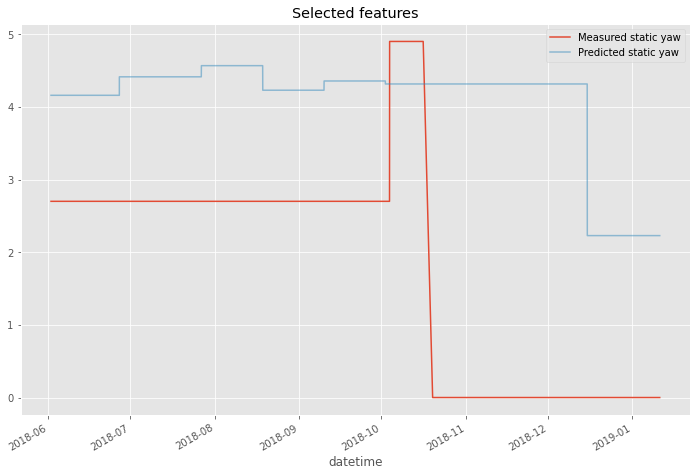

In [13]:
# specify the file to load the trained models from
scaler_file = 'select_bins_yaw_scaler.pickle'
models_file = 'models_bins.pickle.z' 

with open(models_file, 'rb') as file:
    all_models_dict = joblib.load(file)
    
with open(scaler_file, 'rb') as file:
    scaler = pickle.load(file)
    
df_scaled = df.copy().drop(columns='y_pred') 
df_scaled[df_scaled.columns] = scaler.transform(df_scaled)
df_scaled['y'] = df['y']
d = 10
window = d * 1440
df['y_pred'] = np.nan
    
for w in range(0, len(df), window):
    print(f"WINDOW {w}")
    binned_data_dfs = []
    for b in bin_masks:
        df_temp = df_scaled[w:w+window][b[w:w+window]]
        binned_data_dfs.append(df_temp.copy())

    target_feature = 'y'

    all_preds = {}
    for bin_n, d in enumerate(binned_data_dfs):
        dataset_preds = []
        for dataset_key, dataset_dict in all_models_dict.items():
            fit_features = dataset_dict['selected_features']
            models = dataset_dict['models']
            if d.shape[0] >= 100 and models[bin_n] is not None:
                test_preds = predict(d, models[bin_n], fit_features, target_feature)
                dataset_preds.append(test_preds)
            else:
                pass
        if dataset_preds != []:
            all_preds[bin_n] = np.mean(dataset_preds, axis=0)
        else:
            all_preds[bin_n] = None

    for bin_n, b in enumerate(bin_masks):
        if all_preds[bin_n] is not None:
            predictions = all_preds[bin_n]
            df['y_pred'].iloc[w:w+window][b[w:w+window]] = predictions
    df['y_pred'].iloc[w:w+window] = np.mean(df['y_pred'].iloc[w:w+window]) 
prediction = np.abs(df['y_pred'])
target = np.abs(df['y'])

# Calculate RMSE and MAE
rmse = np.sqrt(np.nanmean((prediction.values-target.values)**2))
mae = np.nanmean(np.abs(prediction.values-target.values))
m = (prediction.isna())
print(f"RMSE = {rmse}")
print(f"MAE = {mae}")

df_true_yaw = pd.DataFrame()
df_true_yaw['y'] = np.abs(df['y'])
df_true_yaw['y'].plot(figsize=(12, 8), label = 'Measured static yaw')
df['y_pred'].plot(alpha=0.5, label = 'Predicted static yaw')
plt.title('Selected features')
plt.legend()
plt.show()